In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

In [2]:
study_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\4_M2_V3"
data_dir = os.path.join(study_dir,"data","json")
param_dir = os.path.join(study_dir,"data","param")

# check parameter

In [3]:
parameters_dataset = []
for fn in os.listdir(param_dir):
    with open(os.path.join(param_dir,fn)) as f:
        parameters_dataset.append(json.load(f))

parameters = parameters_dataset[1]
parameters.keys()


dict_keys(['shrink', 'max_bonus', 'nb_levels', 'nb_features', 'step_size', 'move_thres', 'err_tol', 'max_distance_from_centre', 'prevBlock_seq', 'merge_holder', 'fixation_timeout', 'cue_timeout', 'feedback_timeout', 'jitter_timeout', 'blockins_timeout', 'blockres_timeout', 'treahunt_timeout', 'loc2AFC_timeout', 'catch_timeout', 'pracfb_timeout', 'nb_sessions', 'nb_blocks', 'nb_trials', 'max_noresptrials', 'catch_code', 'bonus_lvl', 'nb_distractor', 'conditions', 'stim_dim', 'stim_prop', 'stim_symbols', 'stim_list', 'slist_fields', 'stim_maps', 'map_Dim2Prop', 'map_Prop2Dim', 'map_xprop', 'map_yprop', 'block_restctrl', 'seq_condition', 'seq_task', 'seq_map', 'seq_coordsys', 'seq_curricula', 'seq_tressurelocO', 'seq_tressurelocR', 'seq_distractloc', 'seq_stimID', 'seq_startloc', 'seq_fbctrl', 'seq_catchopts', 'seq_eptctrl', 'seq_rotaterad', 'seq_stim_src', 'path_cond'])

In [4]:
task_seq_fields = [x for x in parameters.keys() if "seq_" in x]
task_sequence_s1 = pd.concat([pd.DataFrame(dict(zip(task_seq_fields,[parameters[x][jblock] for x in task_seq_fields]))).rename_axis('block_trial').reset_index().assign(expt_block=jblock) for jblock in range(parameters["nb_blocks"][0])],
          axis=0).reset_index(drop=True).assign(expt_session=0)
task_sequence_s2 = pd.concat([pd.DataFrame(dict(zip(task_seq_fields,[parameters[x][jblock] for x in task_seq_fields]))).rename_axis('block_trial').reset_index().assign(expt_block=jblock-parameters["nb_blocks"][0]) for jblock in np.arange(parameters["nb_blocks"][1])+parameters["nb_blocks"][0]],
          axis=0).reset_index(drop=True).assign(expt_session=1)
task_sequence = pd.concat([task_sequence_s1,task_sequence_s2],axis=0).reset_index(drop=True).rename_axis('expt_trial').reset_index()
task_sequence.seq_task = pd.Categorical(task_sequence.seq_task,categories=[0,1]).rename_categories(["navigation","2AFC"])
#task_sequence.seq_map = pd.Categorical(task_sequence.seq_task,categories=[0,1,2,3]).rename_categories(["training map 1","training map 2","crossmap1","crossmap2"])

In [39]:
print(np.atleast_2d(task_sequence.seq_task).T)

[['navigation']
 ['navigation']
 ['navigation']
 ...
 ['navigation']
 ['navigation']
 ['navigation']]


In [ ]:
task_sequence

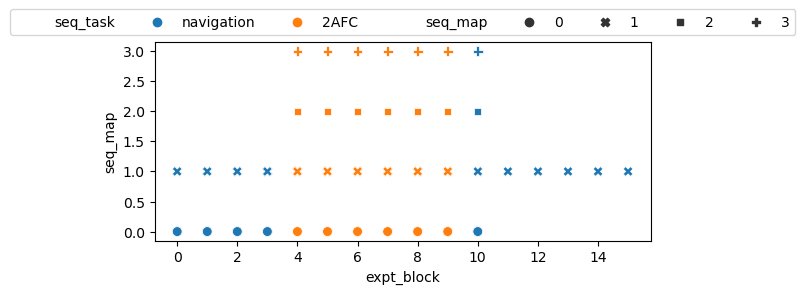

In [45]:
taskseq_ax = sns.scatterplot(data=task_sequence,
            x="expt_block",
            y="seq_map",
            hue="seq_task",
            style="seq_map",
            s=50)
taskseq_ax.set_aspect(2)
sns.move_legend(taskseq_ax,loc="upper center",ncol=8,bbox_to_anchor=(0.5,1.2))

# No participant with incomplete data

In [260]:
#data for H8eke7rnGDxC participant is in tmp
tmp_ids=['H8eke7rnGDxC',
    #"sS3Wh9V8elj8",
    "MJQxtcr3UsX3",
    "g1kuNAPuKrLo",
    "nQSEg1QnM88K"]
for id in tmp_ids:
    txtdat_fn = os.path.join(study_dir,"downloadeddata","session2","tmp","cond_4",f"{id}.txt")
    f = open(txtdat_fn)
    txtdata = f.readlines()
    txtdata[0] = txtdata[0].replace('sdata ','{"sdata" ') + "}"
    txtdata[1] = txtdata[1].replace('edata ','{"edata" ') + "}"
    txtdata[2] = txtdata[2].replace('ddata ','{"ddata" ') + "}"
    txtdata[3] = txtdata[3].replace('parameters ','{"parameters" ') + "}"
    #json.loads(','.join(txtdata))
    #','.join(txtdata)
    data = {}
    for k,t in zip(["sdata","edata","ddata","parameters"],txtdata):
        data[k]=json.loads(t)[k]
    if "bonus_pound" not in data["edata"].keys():
        data["edata"]["bonus_pound"] = data["edata"]["bonus"]/100    
    print(f'{id}: {data["edata"]["bonus_pound"]}')
    with open(os.path.join(data_dir,f"cond4_{id}_session2.json"), 'w') as f:
        json.dump(data,f)

H8eke7rnGDxC: 3.2
MJQxtcr3UsX3: 3.3
g1kuNAPuKrLo: 1.51
nQSEg1QnM88K: 0.35


In [21]:
#print(data["edata"]["bonus_pound"])
print(data["edata"]["bonus_pound"])
len(data["sdata"]["resp_choice"])


2.04


219

# compute bonus for payment

In [46]:
dataset = []
for fn in os.listdir(data_dir):
    with open(os.path.join(data_dir,fn)) as f:
        dataset.append(json.load(f))

bonus_filepath=os.path.join(
    study_dir,
    "bonus.csv"
)
bonus_df = pd.DataFrame(
    np.vstack([[data["edata"]["expt_turker"] for data in dataset],
[data["edata"]["bonus_pound"] for data in dataset],
[data["edata"]["expt_subject"] for data in dataset],
[np.unique(data["sdata"]["expt_session"])[0] for data in dataset]]).T,
columns=["prolificid","bonus","expt_id","session"]
)
bonus_df.to_csv(bonus_filepath)



check one example dataset

In [47]:
data = dataset[1]
print(data.keys())
print(f"edata keys: {data['edata'].keys()}")
for k,v in data["sdata"].items():
    print(f"{k}: {len(v)}")
experiment_df = pd.DataFrame(data["sdata"])
print(experiment_df.head())
data["ddata"]

dict_keys(['sdata', 'edata', 'ddata'])
edata keys: dict_keys(['expt_subject', 'expt_sex', 'expt_age', 'expt_task', 'expt_turker', 'bonus', 'exp_starttime', 'ins_starttime', 'ins_duration', 'tracker_pracCacc', 'bonus_pound', 'exp_finishtime'])
expt_session: 792
expt_index: 792
expt_trial: 792
expt_block: 792
expt_task: 792
expt_cond: 792
expt_coordsys: 792
expt_curricula: 792
expt_map: 792
stim_id: 792
stim_x: 792
stim_y: 792
stim_group: 792
stim_img: 792
start_x: 792
start_y: 792
start_sx: 792
start_sy: 792
distactorside: 792
distractor_x: 792
distractor_y: 792
ctrl_fb: 792
ctrl_ept: 792
time_fixation: 792
time_cue: 792
time_arena: 792
time_response: 792
resp_x: 792
resp_y: 792
resp_sx: 792
resp_sy: 792
resp_dist: 792
resp_choice: 792
resp_rt: 792
resp_acclvl: 792
resp_correct: 792
   expt_session  expt_index  expt_trial  expt_block  expt_task  expt_cond  \
0             1           0           0          16          0          4   
1             1           1           1          16  

{'expbreak': 'Yes, there were enough breaks. Towards the end F/J task seemed little too long to keep attention',
 'ruleverbal': 'Yes, animals were used as X and Y coordinates',
 'challenge': 'Switching from F/J task to attention check\nPressing F or J corresponding to color - sometimes mistakenly pressed based on location',
 'focus': 'Partially - it was hard to switch from F/J task to attention checks and there could be little bit more time to select correct answer from 6 images.',
 'strategy': 'Used pen and paper to note animals and then tried to find animal. If I found only one - I guessed',
 'toolverbal': 'Pen&paper - drew a circle where noted what animals are X and Y axis and then 4 points on each axis for second animal',
 'feedback': '',
 'cluster': {'symID': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19],
  'symattr': ['x1_-2',
   'x1_-1',
   'x1_0',
   'x1_1',
   'x1_2',
   'x2_-2',
   'x2_-1',
   '

# check the bonus file to select participants who finished both days to get valid id

In [49]:
valid_exptid = [
    "1dFS0Yn3T4pK",
    "77WTUkTd6vVM",
    "AGehrPWjRrg5",
    "aweyqilaLvli",
    "aZB1d5MjtO3X",
    "B5AwicapL9Pk",
    "c1aPzh1gcCCI",
    "HWjuRibiOCvE",
    "IbvB3PaXSFwS",
    "kLbiHPqG1T3e",
    "OyD5dzM26OCS",
    "STM71Y6LPdw2",
    "YEefouIzdevm",
    "Z48IBZ3Fij7e",
    "z5RhGaDBons6"
    ]
    
# id with complete 2AFC data: np.unique(loc2AFC_df[loc2AFC_df.expt_block==26].subid)

len(valid_exptid)

15

## organize all the task data

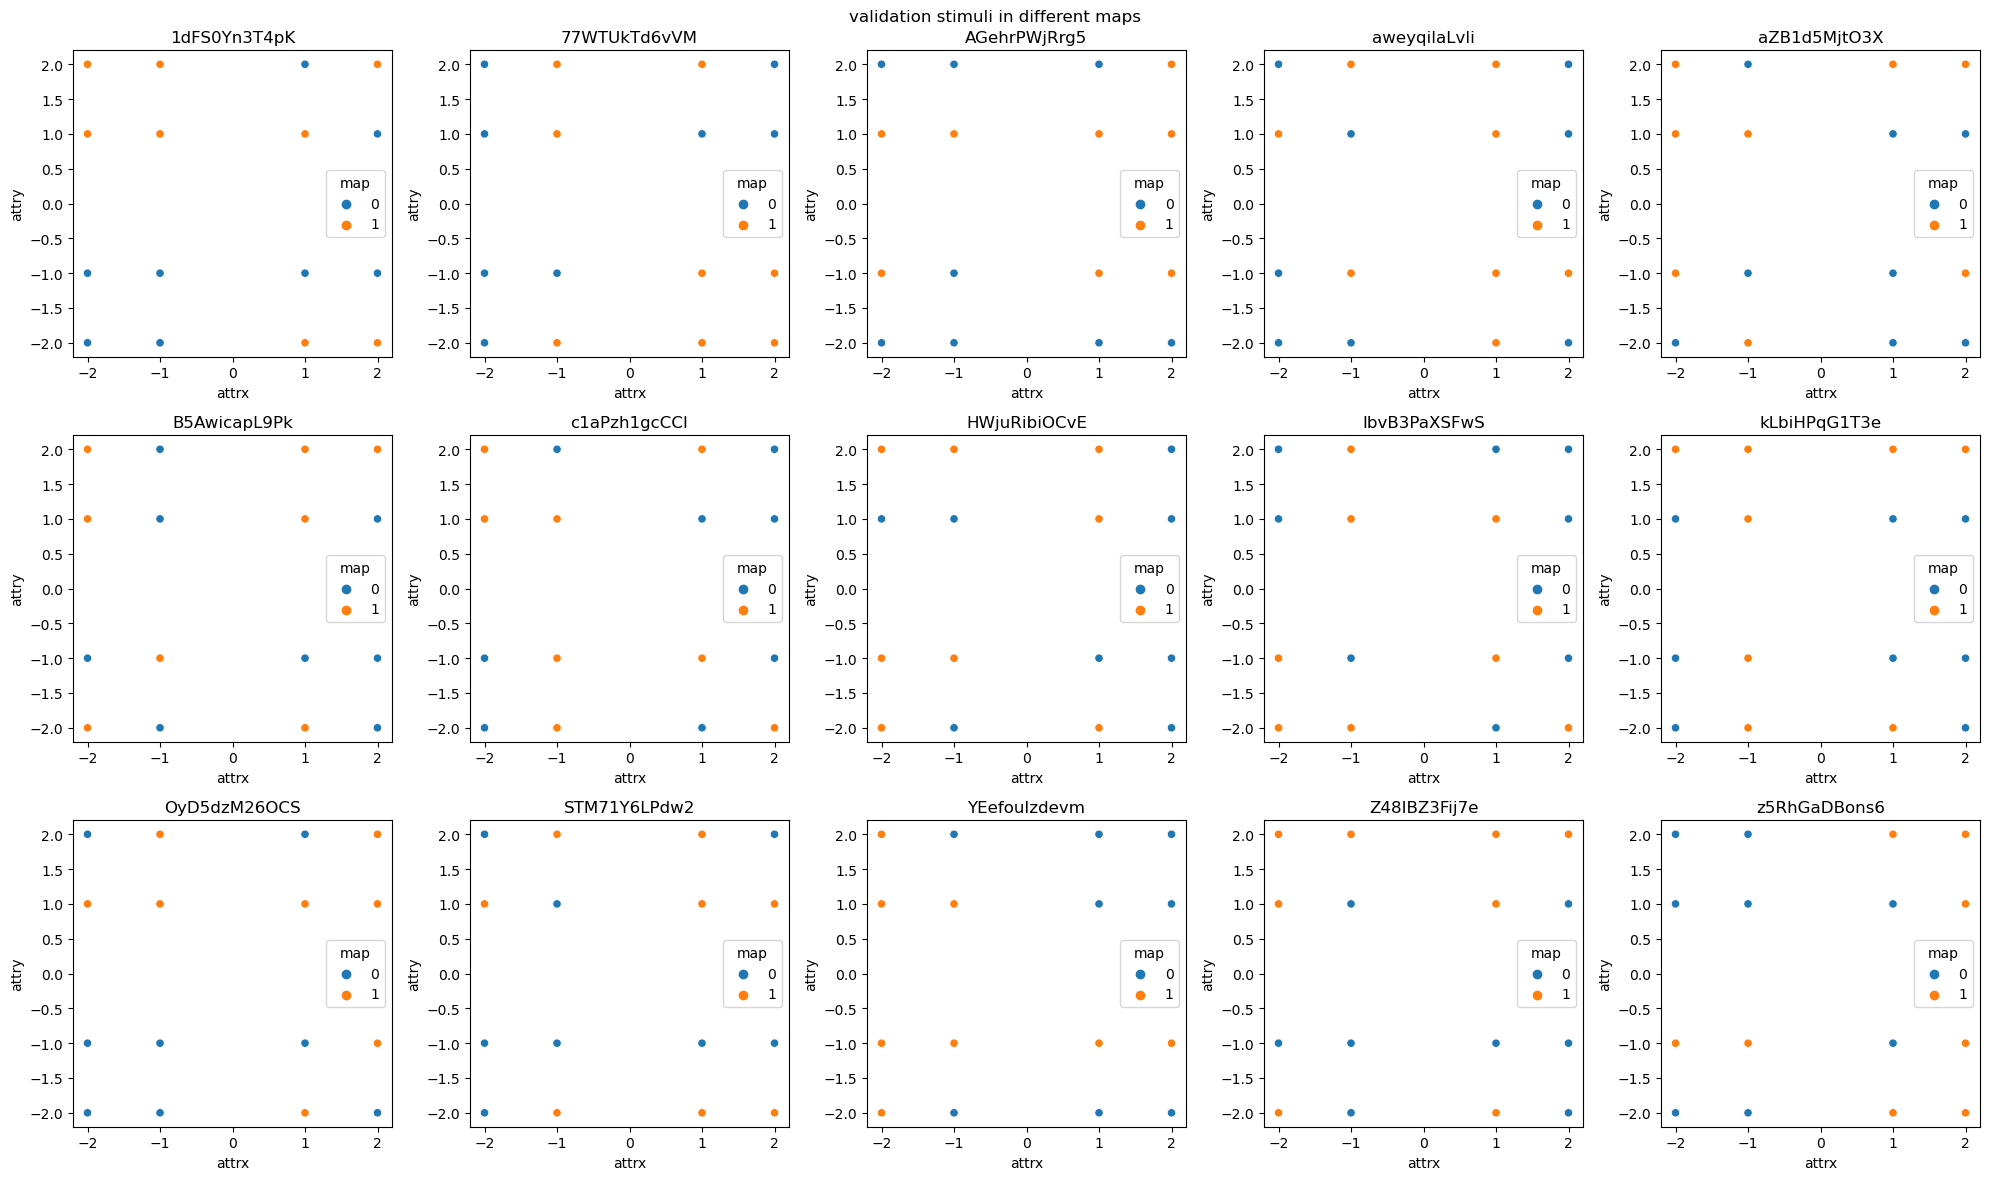

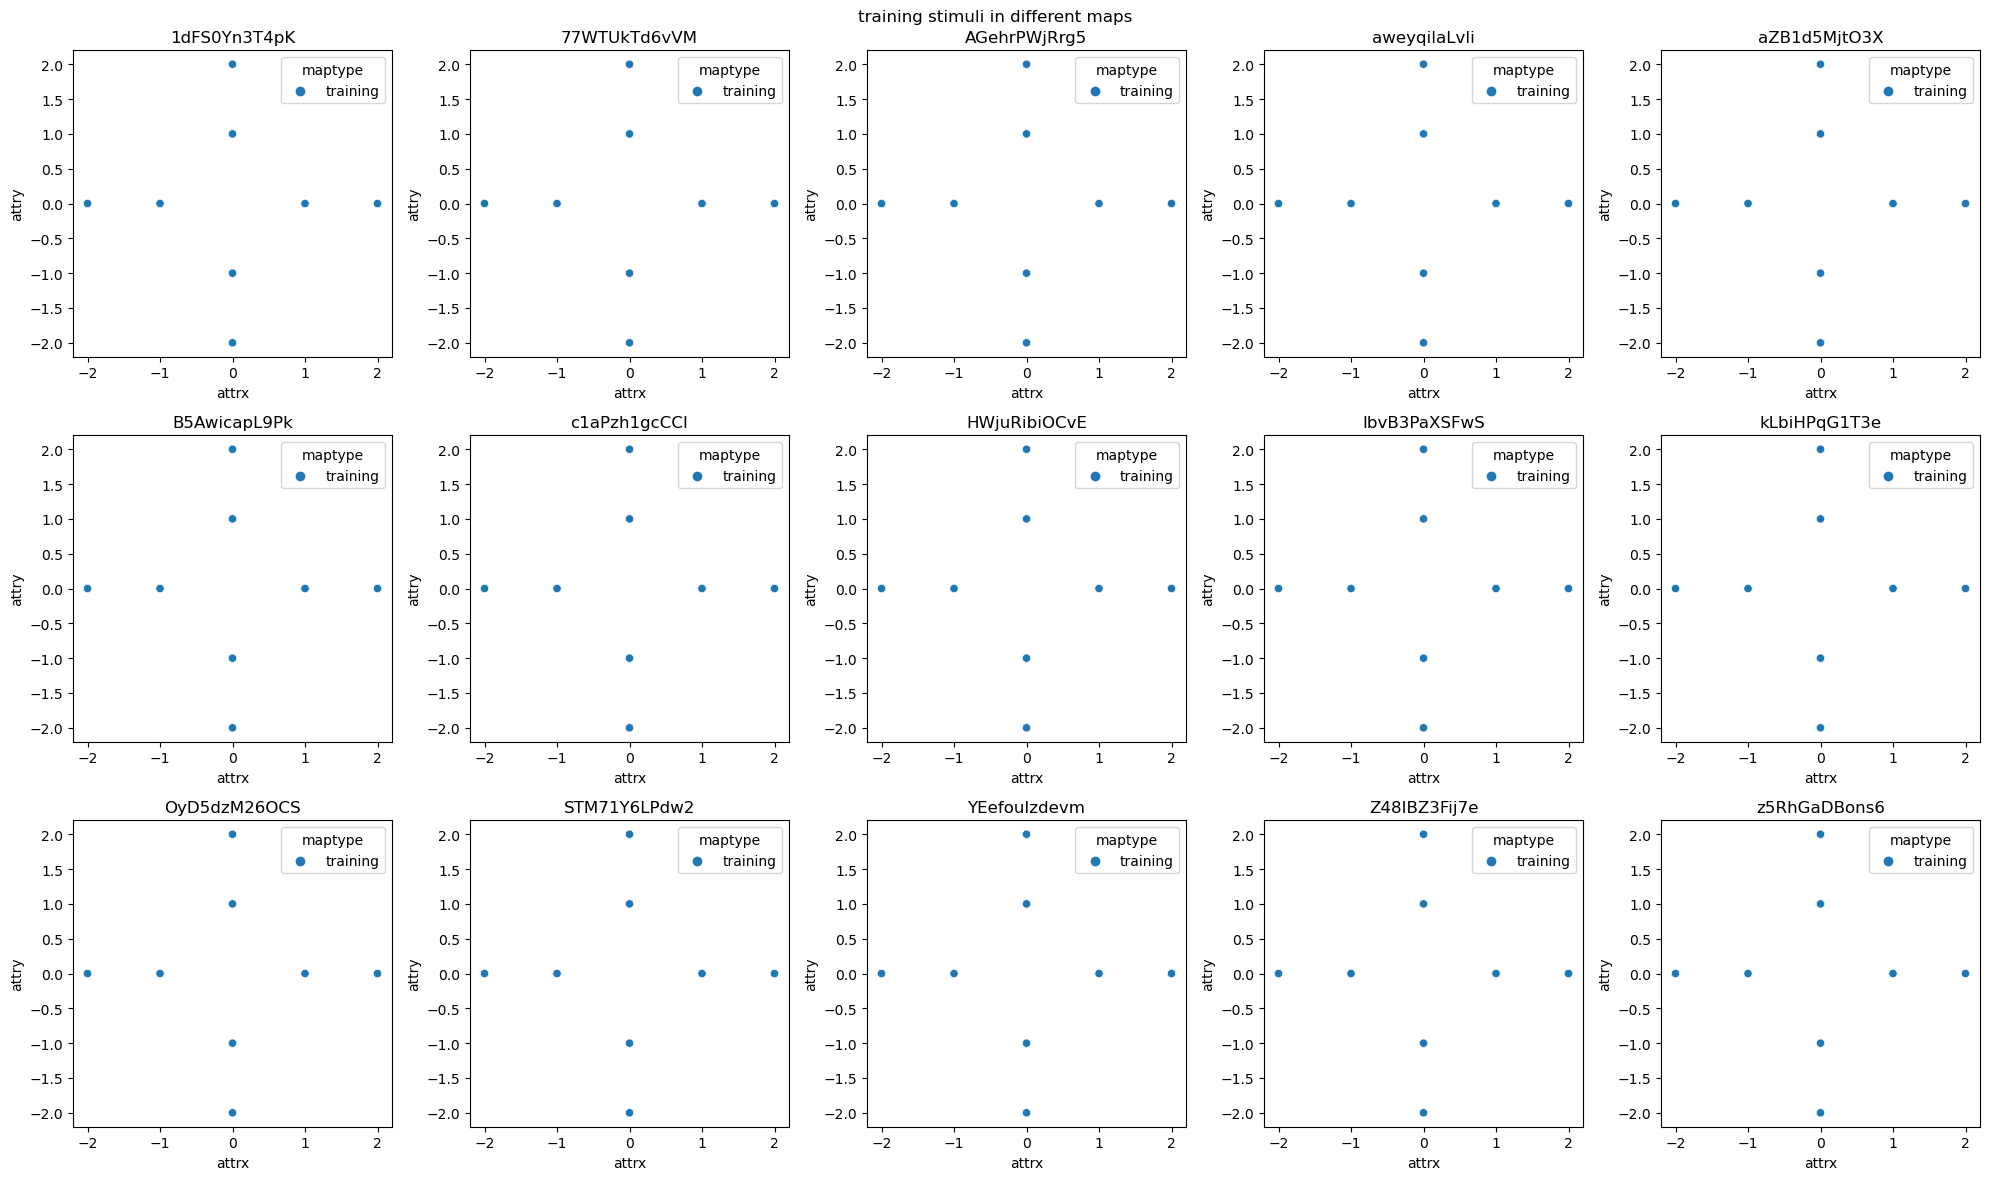

In [50]:
ncol = min([5,len(valid_exptid)])
nrow = int(np.ceil(len(valid_exptid)/ncol))
stimsplit_fig,stimsplit_axes = plt.subplots(nrow,ncol,figsize=(ncol*4,nrow*4))
for jsub,id in enumerate(valid_exptid):
    param_file = os.path.join(param_dir,f"param_{id}.json")
    with open(param_file) as f:
        param = json.load(f)
        stim_list = param["stim_list"]

    stimdf=pd.DataFrame(stim_list,
                        columns=list(param["slist_fields"].keys()))
    valid_filt = stimdf["stimuligroup"] == "validation"
    maps_filt = [stimdf["map"] == j for j in range(4)]
    stimdf["maptype"] = ["training" if map in [0,1] else "cross" for map in np.array(stimdf["map"])]
    trainingmap_filt = stimdf["maptype"] == "training"
    validation_df = stimdf[valid_filt]
    curr_ax = stimsplit_axes.flatten()[jsub]
    sns.scatterplot(
        validation_df,
        x="attrx",y="attry",hue="map",
        ax=curr_ax)
    curr_ax.set_title(id)

if stimsplit_axes.size>len(valid_exptid):
    for ax in stimsplit_axes.flatten()[len(valid_exptid):]:
        ax.remove()
stimsplit_fig.suptitle("validation stimuli in different maps")
stimsplit_fig.tight_layout()

#### training stim
ncol = min([5,len(valid_exptid)])
nrow = int(np.ceil(len(valid_exptid)/ncol))
stimsplit_fig,stimsplit_axes = plt.subplots(nrow,ncol,figsize=(ncol*4,nrow*4))
for jsub,id in enumerate(valid_exptid):
    param_file = os.path.join(param_dir,f"param_{id}.json")
    with open(param_file) as f:
        param = json.load(f)
        stim_list = param["stim_list"]

    stimdf=pd.DataFrame(stim_list,
                        columns=list(param["slist_fields"].keys()))
    valid_filt = stimdf["stimuligroup"] == "training"
    maps_filt = [stimdf["map"] == j for j in range(4)]
    stimdf["maptype"] = ["training" if map in [0,1] else "cross" for map in np.array(stimdf["map"])]
    trainingmap_filt = stimdf["maptype"] == "training"
    crossmap_filt = stimdf["maptype"] == "cross"
    validation_df = stimdf[valid_filt]
    curr_ax = stimsplit_axes.flatten()[jsub]
    sns.scatterplot(
        validation_df,
        x="attrx",y="attry",hue="maptype",
        ax=curr_ax)
    curr_ax.set_title(id)

if stimsplit_axes.size>len(valid_exptid):
    for ax in stimsplit_axes.flatten()[len(valid_exptid):]:
        ax.remove()
stimsplit_fig.suptitle("training stimuli in different maps")
stimsplit_fig.tight_layout()

In [68]:
dataset = []
data_dfs = []
for id in valid_exptid:
    data_files = [os.path.join(data_dir,f"cond4_{id}_session1.json"),os.path.join(data_dir,f"cond4_{id}_session2.json")]
    #data_files = [os.path.join(data_dir,f"cond4_{id}_session1.json")]
    param_file = os.path.join(param_dir,f"param_{id}.json")
    with open(param_file) as f:
            param = json.load(f)
            stim_list = param["stim_list"]
    subdfs = []
    for fn in data_files:
        with open(os.path.join(fn)) as f:
            data = json.load(f)
            dataset.append(data)
            subdfs.append(pd.DataFrame(data["sdata"]).assign(prolificid=data['edata']['expt_turker'],subid=id))
    subdf = pd.concat(subdfs).reset_index(drop=True)
    subdf["istraining"] = subdf["stim_group"] == "training"
    subdf["x_axisset"]  = ["x1" if m in [0,2] else "x2" for m in subdf.expt_map.to_numpy()]
    subdf["y_axisset"]  = ["y1" if m in [0,3] else "y2" for m in subdf.expt_map.to_numpy()]
    data_dfs.append(subdf)

org_data = pd.concat(data_dfs).reset_index(drop=True).fillna(value=np.nan)
print(org_data.dtypes)

bool2int_columns = ["ctrl_fb","ctrl_ept","istraining"]
for k in bool2int_columns:
    org_data[k] = org_data[k].astype(int)
print(org_data.dtypes)

org_data["resp_correct"] = org_data["resp_correct"].astype(int)

print(org_data.dtypes)
org_data.to_csv(os.path.join(study_dir,"task_data.csv"))

expt_session        int64
expt_index          int64
expt_trial          int64
expt_block          int64
expt_task           int64
expt_cond           int64
expt_coordsys       int64
expt_curricula      int64
expt_map            int64
stim_id             int64
stim_x            float64
stim_y            float64
stim_group         object
stim_img           object
start_x           float64
start_y           float64
start_sx          float64
start_sy          float64
distactorside     float64
distractor_x      float64
distractor_y      float64
ctrl_fb              bool
ctrl_ept             bool
time_fixation       int64
time_cue            int64
time_arena          int64
time_response       int64
resp_x            float64
resp_y            float64
resp_sx           float64
resp_sy           float64
resp_dist         float64
resp_choice       float64
resp_rt             int64
resp_acclvl       float64
resp_correct       object
prolificid         object
subid              object
istraining  

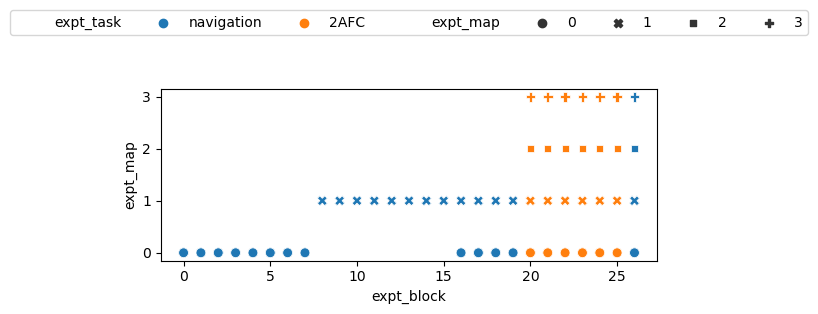

In [78]:
seq_df = subdf.copy()
seq_df["expt_index"] = seq_df.index
seq_df.expt_task = pd.Categorical(seq_df.expt_task,categories=[0,1]).rename_categories(["navigation","2AFC"])
taskseq_ax = sns.scatterplot(data=seq_df,
            x="expt_block",
            y="expt_map",
            hue="expt_task",
            style="expt_map",
            s=50)
taskseq_ax.set_aspect(3)
sns.move_legend(taskseq_ax,loc="upper center",ncol=8,bbox_to_anchor=(0.5,1.5))

### Plot basic summary statistics for checking

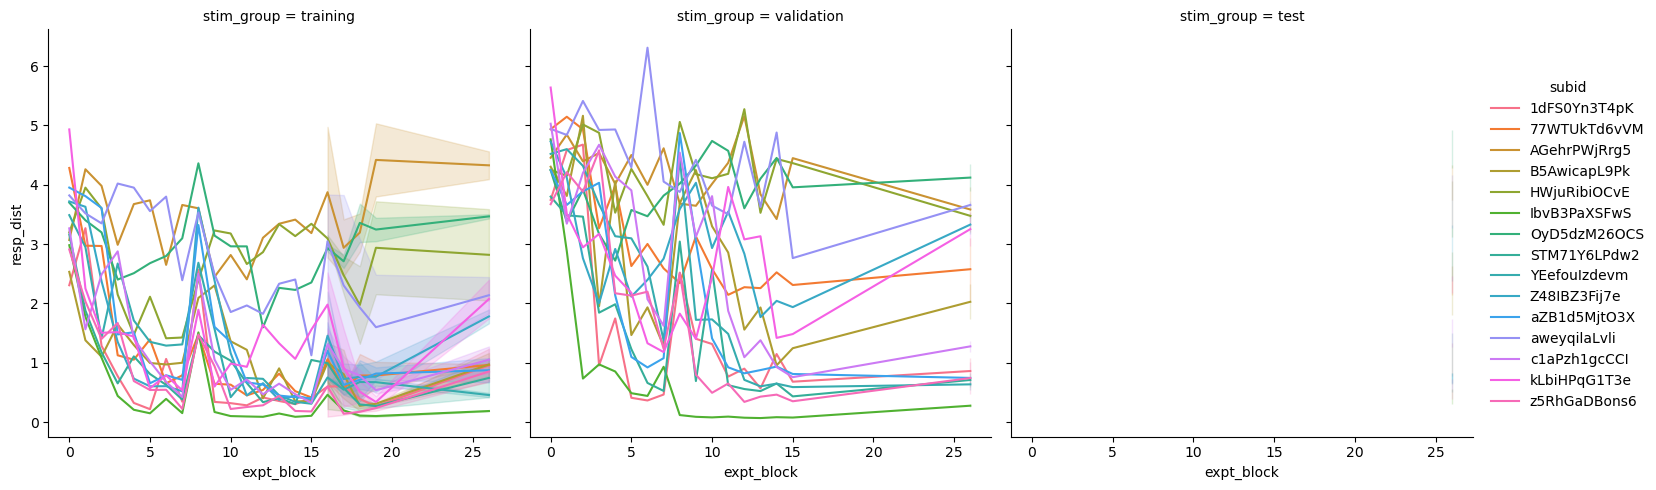

In [79]:
treasurehunt_df = org_data[org_data.expt_task==0].copy()
treasurehunt_sum_df = treasurehunt_df.groupby(["subid","expt_map","expt_session","expt_task","expt_block","stim_group"])[["resp_dist","resp_rt"]].mean().reset_index()
treasurehunt_sum_df.head(5)
sns.relplot(treasurehunt_sum_df,x="expt_block",y="resp_dist",hue="subid",col="stim_group",kind="line")


In [80]:
loc2AFC_df = org_data[org_data.expt_task==1].copy()
print(loc2AFC_df.columns)
loc2AFC_df.head(5)

Index(['expt_session', 'expt_index', 'expt_trial', 'expt_block', 'expt_task',
       'expt_cond', 'expt_coordsys', 'expt_curricula', 'expt_map', 'stim_id',
       'stim_x', 'stim_y', 'stim_group', 'stim_img', 'start_x', 'start_y',
       'start_sx', 'start_sy', 'distactorside', 'distractor_x', 'distractor_y',
       'ctrl_fb', 'ctrl_ept', 'time_fixation', 'time_cue', 'time_arena',
       'time_response', 'resp_x', 'resp_y', 'resp_sx', 'resp_sy', 'resp_dist',
       'resp_choice', 'resp_rt', 'resp_acclvl', 'resp_correct', 'prolificid',
       'subid', 'istraining', 'x_axisset', 'y_axisset'],
      dtype='object')


,expt_session,expt_index,expt_trial,expt_block,expt_task,expt_cond,expt_coordsys,expt_curricula,expt_map,stim_id,...,resp_dist,resp_choice,resp_rt,resp_acclvl,resp_correct,prolificid,subid,istraining,x_axisset,y_axisset
464,1,64,0,20,1,4,0,2,0,10,...,NaN,NaN,1009,NaN,1,5e7d14363629230c5f6cdd0c,1dFS0Yn3T4pK,0,x1,y1
465,1,65,1,20,1,4,0,2,1,79,...,NaN,1.0,574,NaN,0,5e7d14363629230c5f6cdd0c,1dFS0Yn3T4pK,1,x2,y2
466,1,66,2,20,1,4,0,2,1,97,...,NaN,5.0,3805,NaN,1,5e7d14363629230c5f6cdd0c,1dFS0Yn3T4pK,1,x2,y2
467,1,67,3,20,1,4,0,2,3,72,...,NaN,0.0,718,NaN,1,5e7d14363629230c5f6cdd0c,1dFS0Yn3T4pK,0,x2,y1
468,1,68,4,20,1,4,0,2,1,66,...,NaN,1.0,553,NaN,0,5e7d14363629230c5f6cdd0c,1dFS0Yn3T4pK,0,x2,y2


In [81]:
print(f"dropped {((np.isnan(loc2AFC_df['resp_choice']).sum())/loc2AFC_df.shape[0])*100}% of trials")
#loc2AFC_df = loc2AFC_df.dropna(subset=["resp_choice"])
loc2AFC_df = loc2AFC_df[loc2AFC_df.ctrl_ept==1].copy().reset_index(drop=True)
#loc2AFC_df["resp_correct"] = np.array(loc2AFC_df["resp_choice"] != loc2AFC_df["distactorside"])*1
loc2AFC_df["maptype"] = ["training" if map in [0,1] else "cross" for map in np.array(loc2AFC_df["expt_map"])]
loc2AFC_df["stimtype"] = ["center" if np.logical_xor(x==0,y==0) else "offcenter" for x,y in np.array(loc2AFC_df[["stim_x","stim_y"]])]


dropped 6.730769230769231% of trials


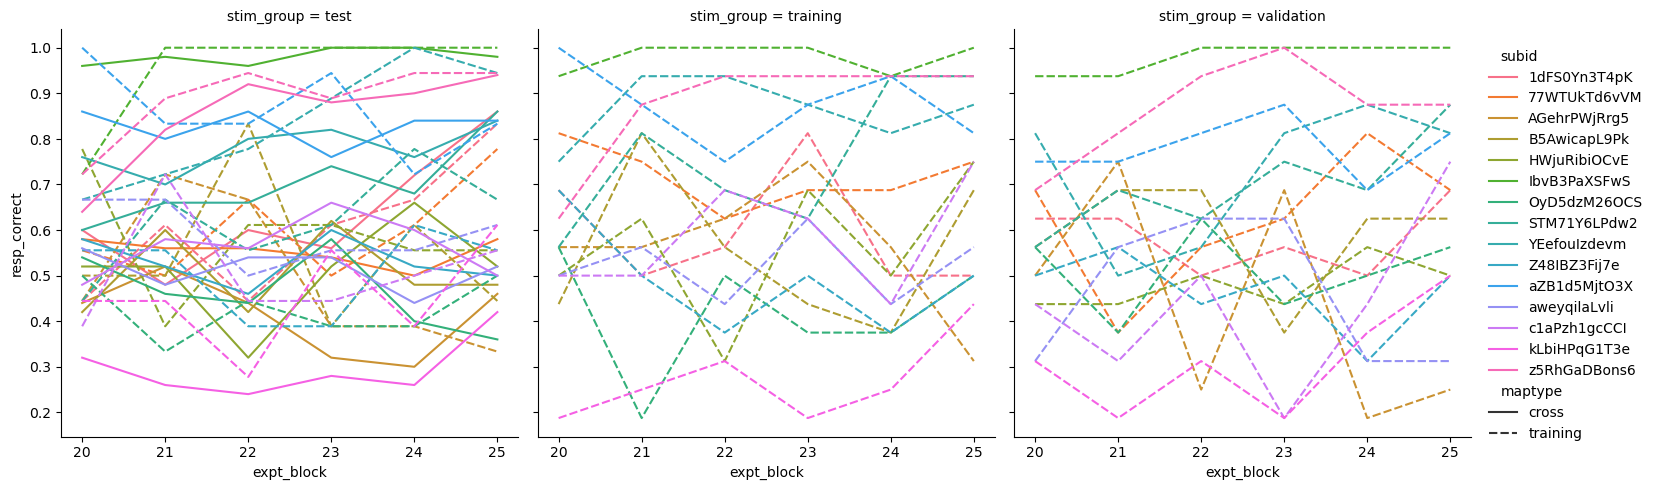

In [83]:
loc2AFC_sum_df = loc2AFC_df.groupby(["subid","maptype","stim_group","expt_block"])[["resp_rt","resp_correct"]].mean().reset_index()
loc2AFC_sum_df.head(5)
sns.relplot(loc2AFC_sum_df,x="expt_block",y="resp_correct",style="maptype",col="stim_group",hue="subid",kind="line")

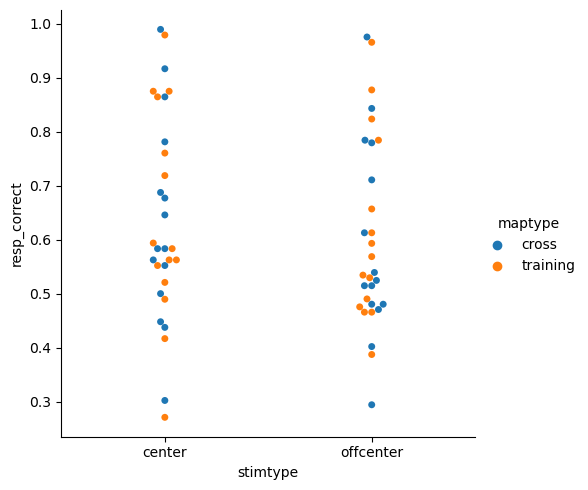

In [84]:
loc2AFC_sum_df = loc2AFC_df.groupby(["subid","maptype","stimtype"])["resp_correct"].mean().reset_index()
loc2AFC_sum_df.head(5)
#sns.catplot(loc2AFC_sum_df,x="stimtype",y="resp_correct",hue="maptype",kind="bar",errorbar="se")
sns.catplot(loc2AFC_sum_df,x="stimtype",y="resp_correct",hue="maptype",kind="swarm",errorbar="se")
#sns.catplot(loc2AFC_sum_df,x="stimtype",y="resp_correct",col="maptype",hue="subid",units="subid",kind="swarm")

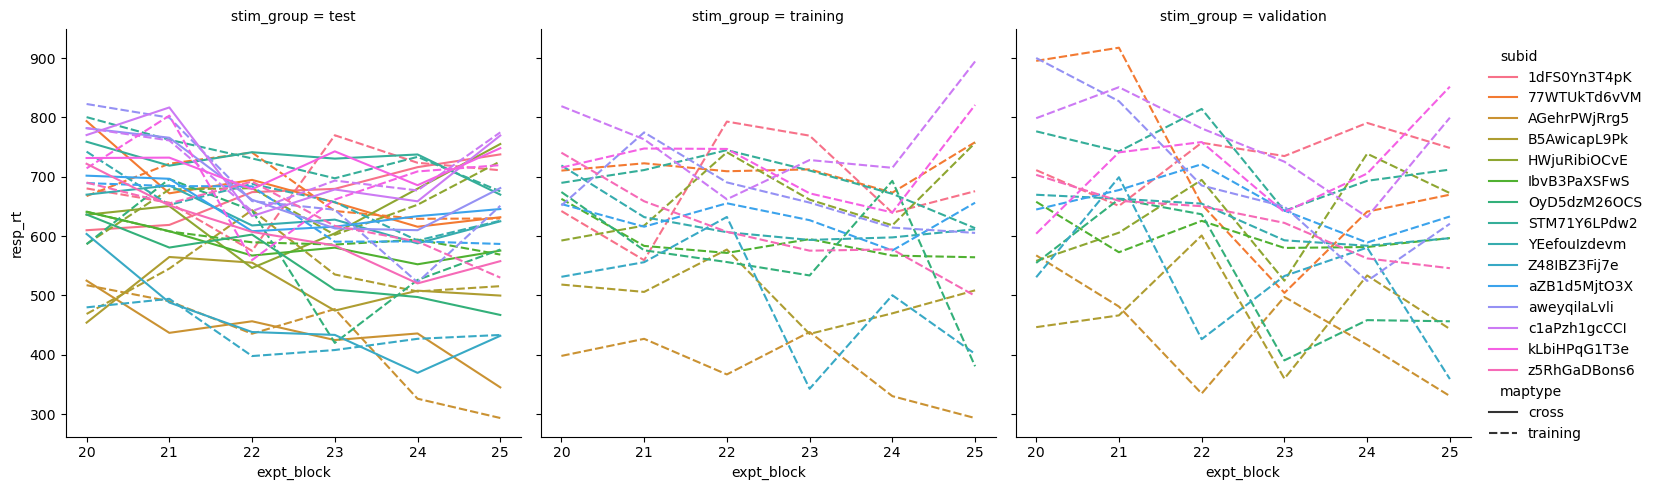

In [85]:
loc2AFC_rtsum_df = loc2AFC_df[loc2AFC_df.resp_correct==1].groupby(["subid","maptype","stim_group","expt_block"])["resp_rt"].mean().reset_index()
sns.relplot(loc2AFC_rtsum_df,x="expt_block",y="resp_rt",hue="subid",col="stim_group",style="maptype",kind="line")

## organize debrief data

In [86]:
dataset = []
cluster_data_dfs = []
debrief_data_dfs = []
for k,id in enumerate(valid_exptid):
    fn = os.path.join(data_dir,f"cond4_{id}_session2.json")
    param_file = os.path.join(param_dir,f"param_{id}.json")
    with open(fn) as f:
        data = json.load(f)
        dataset.append(data)
        if "cluster" in data['ddata'].keys():
            cluster_task_data = data['ddata'].pop("cluster")
            cluster_data_dfs.append(pd.DataFrame(cluster_task_data).assign(prolificid=data['edata']['expt_turker'],subid=id))
            debrief_data_dfs.append(pd.DataFrame(data['ddata'],index=[k]).assign(prolificid=data['edata']['expt_turker'],subid=id))
    with open(param_file) as f:
        param = json.load(f)

In [87]:
cluster_df = pd.concat(cluster_data_dfs).reset_index(drop=True)
debrief_df = pd.concat(debrief_data_dfs).reset_index(drop=True)
cluster_df.to_csv(os.path.join(study_dir,"cluster_data.csv"))
debrief_df.to_csv(os.path.join(study_dir,"debrief_data.csv"))

In [88]:
np.unique(cluster_df.subid).size

15